In [25]:
# ============================================================
# SECTION 1 — Imports and Data Loading
# ============================================================

# Install required packages
!pip install neuroCombat umap-learn --quiet
!pip install -U scikit-learn

# Core libraries 
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from sklearn.ensemble import RandomForestClassifier



#  Preprocessing & dimensionality reduction 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from sklearn.ensemble import RandomForestClassifier
import umap
import seaborn as sns
import matplotlib.pyplot as plt
#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from neuroCombat import neuroCombat
# Batch correction
from neuroCombat import neuroCombat
from neuroCombat import neuroCombat
from sklearn.decomposition import PCA

# --- Imports ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import umap
from sklearn.metrics import silhouette_score
from neuroCombat import neuroCombat

# Set visualization style
sns.set(style="whitegrid", context="talk")

# Load the dataset

filename = "/Users/qayyumayesha/bioinformatics/Scientific programming/Programming project/ABC_targeted_data/FORAGI_ABC_Compilation_AMOUNTS_AllABCTargets_BreathEquipmentAmbient_Non-imputed_Non-normalized_LinkedtoDemographics_21JUL25.xlsx"

# Load Excel file
df = pd.read_excel(filename, engine="openpyxl")

print(f"Dataset loaded successfully! Shape: {df.shape}")
display(df.head())


Dataset loaded successfully! Shape: (440, 174)


,Seq,Label,Sample,E-CRC number,Sex,Weight,Length,English Co-morbidity,WHO ICD classification,Informal classification,...,Chromone,Indole,3-Methylindole,2-Coumaranone,2-Cyclohexylphenol,Hydroquinone,Phenalen-1-one,Benzofuran-2-yl(phenyl)methanone,Diphenylmaleic anhydride,"2,6-Diphenylphenol"
0,1,Breath,ABC00231643275309,E-CRC_MUMC_0022,1,75,173,pulmonary hypertension;asthma,MIXED: I00-I99 (Diseases of the circulatory sy...,Heart/circulation/Lung,...,0.126287,0.110289,0.094603,0.972521,0.224213,0.378588,0.167271,0.281357,0.297815,1.328503
1,1,Breath,AB203471689671209,E-CRC_MUMC_0344,0,118,183,High blood pressure;High cholesterol;Burnout,MIXED,Heart/circulation/Stress,...,0.103582,0.079161,0.088392,0.963517,0.090406,0.128813,0.135689,0.42075,1.196269,2.77295
2,1,Breath,AB202681675325449,E-CRC_MUMC_0265,1,71,167,Skin cancer (basal),L00-L99 (Diseases of the skin and subcutaneous...,Skin,...,0.068203,1.419938,0.158205,0.967715,0.163888,0.06588,0.117629,0.163844,0.123753,1.025276
3,1,Breath,AB202151668676148,E-CRC_MUMC_0244,1,70,177,Worn out knees,M00-M99 (Diseases of the musculoskeletal syste...,Musculoskeletal,...,0.066195,0.072170,0.08377,0.964371,0.208340,n.a.,0.113724,0.185064,0.103272,1.008471
4,1,Breath,AB201251655373952,E-CRC_MUMC_0114,0,90,193,NaN,NaN,NaN,...,0.06912,0.207886,0.085486,n.a.,0.184186,0.149496,0.108431,0.184782,0.080297,1.027871


/var/folders/cd/2pthfxks1cv32d9l420hs0_c0000gn/T/ipykernel_1178/1669711811.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(['n.a.', 'n.a', 'N.A.', 'N./A as blank'], np.nan, inplace=True)


 Biological samples retained: 175
Group
Low Risk Adenoma     121
High Risk Adenoma     54
Name: count, dtype: int64
 Identified 150 potential VOC columns starting from: 2-Pentene, (Z)
 VOCs kept after missingness filtering: 110
 Data prepared for batch correction. Shape: (175, 110)
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
 neuroCombat batch correction complete!
Using 18 top VOCs for URF analysis.
 Data scaled for Random Forest modeling.
 Unsupervised Random Forest trained successfully.
 Proximity matrix computed.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


 Silhouette score (HRA vs LRA): 0.110


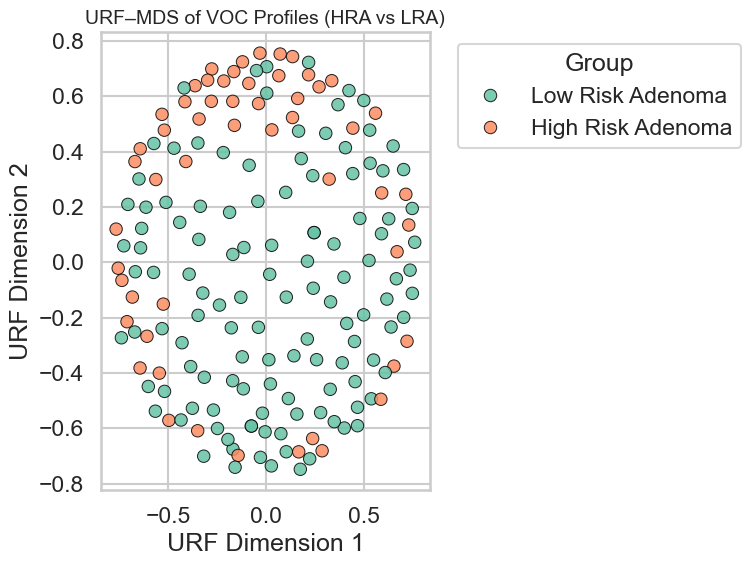

In [27]:
"""
Goal:
To prepare the dataset for unsupervised learning and visualize intrinsic structure
between high-risk (HRA) and low-risk (LRA) adenoma samples.

Approach:
1. Clean and filter biological samples (remove blanks, standardize labels).
2. Identify valid VOC features based on missingness (<30% per subgroup).
3. Impute missing values using k-Nearest Neighbors (kNN) to preserve local patterns.
4. Log-transform and correct batch effects using neuroCombat.
5. Focus analysis on biologically relevant (top) VOCs from prior importance.
6. Apply Unsupervised Random Forest (URF) to capture complex non-linear similarities.
7. Visualize sample relationships with Multidimensional Scaling (MDS).
8. Quantify group separation using the Silhouette score.

Note : this is the figure that was shown in the presentation. In the following sections of this script, the code is improved.
"""

#CLEANUP AND SUBGROUP SELECTION
# Replace "n.a." etc. with NaN for consistency
df.replace(['n.a.', 'n.a', 'N.A.', 'N./A as blank'], np.nan, inplace=True)

# Keep only biological samples: High- and Low-Risk Adenoma (2 & 3)
df_real = df[df['Study subgroup'].isin([2, 3])].copy()

# Remove any rows with 'blank' in the Label column
df_real = df_real[~df_real['Label'].str.contains('blank', case=False, na=False)]

# Ensure numeric and clean subgroup column
df_real = df_real[pd.to_numeric(df_real['Study subgroup'], errors='coerce').notna()]
df_real['Study subgroup'] = df_real['Study subgroup'].astype(int)

# Map subgroup codes to readable names
subgroup_map = {2: 'High Risk Adenoma', 3: 'Low Risk Adenoma'}
df_real['Group'] = df_real['Study subgroup'].map(subgroup_map)

print(f" Biological samples retained: {df_real.shape[0]}")
print(df_real['Group'].value_counts())

#IDENTIFY VOC COLUMNS
voc_start_col = None
for col in df.columns:
    if col.lower().startswith('2-pentene'):
        voc_start_col = col
        break

if voc_start_col is None:
    raise ValueError(" Could not find '2-Pentene' start column in dataset!")

voc_start_idx = df.columns.get_loc(voc_start_col)
metabolite_cols = df.columns[voc_start_idx:]
print(f" Identified {len(metabolite_cols)} potential VOC columns starting from: {voc_start_col}")

# Convert all VOC columns to numeric
df[metabolite_cols] = df[metabolite_cols].apply(pd.to_numeric, errors='coerce')

#FILTER VOCS BASED ON MISSINGNESS (HRA & LRA ONLY)
final_vocs = []
for col in metabolite_cols:
    drop_count = 0
    for subgroup in [2, 3]:
        subgroup_mask = df_real['Study subgroup'] == subgroup
        missing_pct = df_real.loc[subgroup_mask, col].isna().mean() * 100
        if missing_pct > 30:
            drop_count += 1
    if drop_count <= 1:  # keep if missing in ≤ 1 subgroup
        final_vocs.append(col)

print(f" VOCs kept after missingness filtering: {len(final_vocs)}")

#KNN IMPUTATION + LOG TRANSFORMATION
X = df_real[final_vocs].copy()

# Apply 3-nearest-neighbor imputation
imputer = KNNImputer(n_neighbors=3)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Remove zero-variance features (flat signals)
X_nonzero = X_imputed.loc[:, X_imputed.var() > 0]

# Log-transform to reduce skewness
X_log = np.log1p(X_nonzero)

print(f" Data prepared for batch correction. Shape: {X_log.shape}")

# BATCH CORRECTION WITH neuroCombat
# ============================================================
covars = pd.DataFrame({
    'Batch': df_real['Seq'],
    'Subgroup': df_real['Study subgroup']
}, index=df_real.index)

combat_result = neuroCombat(
    dat=X_log.T,
    covars=covars,
    batch_col='Batch',
    categorical_cols=['Subgroup']
)

X_combat = pd.DataFrame(
    combat_result['data'].T,
    index=X_log.index,
    columns=X_log.columns
)

print(" neuroCombat batch correction complete!")

#DEFINE MANUALLY SELECTED TOP VOCS (FROM LITERATURE OR FEATURE IMPORTANCE)
#these are based on the RF top 20 features from the presentation, since then the code was improved but 
# the top 20 features didn't change much 
top_vocs = [
    '4-Heptanone', '2,5-Dimethylstyrene', 'Propylene glycol', 'Valencene_Peak1',
    '4-Ethylphenol', '2-Methoxyethanol', '1-Propanol', '3-Methylindole', 'Indole',
    'Acetic acid', 'Dimethyl trisulfide', 'Dimethyl disulfide',
    '4-Methyl-2(5H)-furanone', 'Bis(methylthio)methane',
    'Diethylene glycol monoethyl ether', 'Pyridine', 'Chlorobenzene',
    'Pyrrole-2-carboxaldehyde', '1,3,5-Triazine', '2-Heptanone'
]

# Keep only those present in the dataset
top_vocs = [v for v in top_vocs if v in X_combat.columns]
print(f"Using {len(top_vocs)} top VOCs for URF analysis.")
X_rf = X_combat[top_vocs].copy()

# STANDARD SCALING
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_rf),
    columns=X_rf.columns,
    index=X_rf.index
)

print(" Data scaled for Random Forest modeling.")


# UNSUPERVISED RANDOM FOREST (URF) + HRA BOOTSTRAPPING
hra_idx = df_real[df_real['Group'] == 'High Risk Adenoma'].index
lra_idx = df_real[df_real['Group'] == 'Low Risk Adenoma'].index

n_hra_needed = len(lra_idx) - len(hra_idx)
if n_hra_needed > 0:
    hra_bootstrap_idx = np.random.choice(hra_idx, size=n_hra_needed, replace=True)
    X_scaled_augmented = pd.concat([X_scaled, X_scaled.loc[hra_bootstrap_idx]], axis=0)
else:
    X_scaled_augmented = X_scaled.copy()

X_perm = X_scaled_augmented.apply(np.random.permutation, axis=0).values
X_aug = np.vstack([X_scaled_augmented.values, X_perm])
y_rf = np.concatenate([np.ones(X_scaled_augmented.shape[0]), np.zeros(X_perm.shape[0])])

rf = RandomForestClassifier(
    n_estimators=4000,
    max_features='sqrt',
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_aug, y_rf)
print(" Unsupervised Random Forest trained successfully.")

# PROXIMITY MATRIX COMPUTATION
leaf_indices = rf.apply(X_aug)
leaf_real = leaf_indices[:X_scaled_augmented.shape[0]]

# Compute proximity matrix only for original samples
n_samples = X_scaled.shape[0]
proximity = np.mean(
    leaf_real[:n_samples, None, :] == leaf_real[:n_samples, None, :].transpose(1, 0, 2),
    axis=2
)

print(" Proximity matrix computed.")

#MDS EMBEDDING + VISUALIZATION
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
embedding = mds.fit_transform(1 - proximity)
df_real['URF_PC1'] = embedding[:, 0]
df_real['URF_PC2'] = embedding[:, 1]

# Compute Silhouette Score (HRA vs LRA)
X_emb = df_real[['URF_PC1', 'URF_PC2']].values
labels = df_real['Group'].values
sil_score = silhouette_score(X_emb, labels)
print(f" Silhouette score (HRA vs LRA): {sil_score:.3f}")

#  Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='URF_PC1', y='URF_PC2',
    hue='Group',
    data=df_real,
    palette='Set2',
    s=80,
    edgecolor='black',
    alpha=0.85
)
plt.title('URF–MDS of VOC Profiles (HRA vs LRA)', fontsize=14)
plt.xlabel('URF Dimension 1')
plt.ylabel('URF Dimension 2')
plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


 Loaded file: /Users/qayyumayesha/bioinformatics/Scientific programming/Programming project/ABC_targeted_data/FORAGI_ABC_Compilation_AMOUNTS_AllABCTargets_BreathEquipmentAmbient_Non-imputed_Non-normalized_LinkedtoDemographics_21JUL25.xlsx, shape = (440, 174)
 VOCs kept after missingness filter: 110
Kept 68 significant VOCs after blank filtering.


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


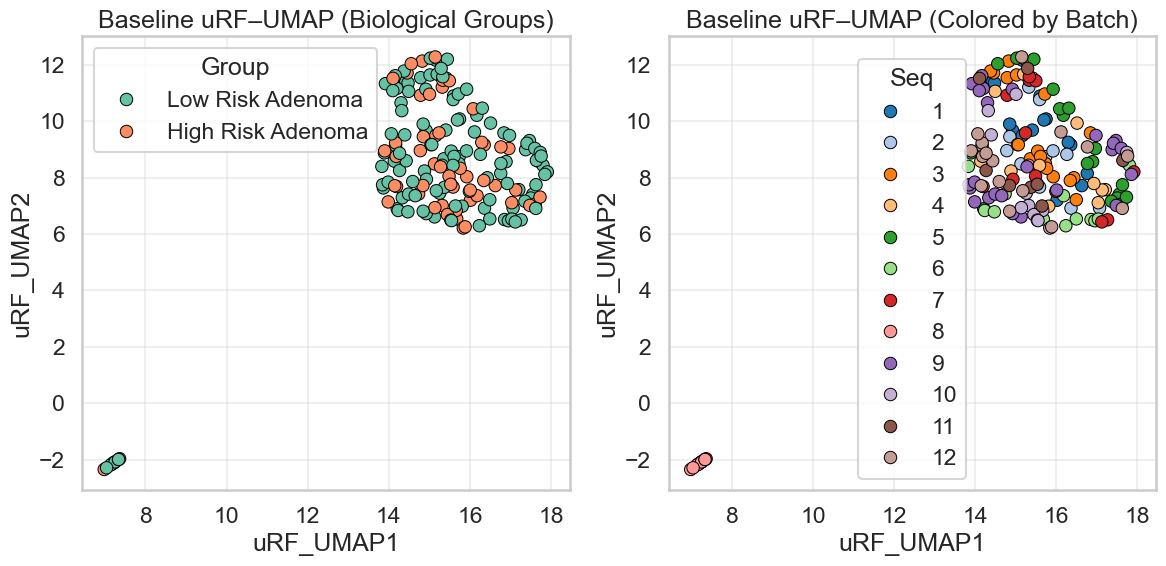

In [43]:
# ============================================================
# SECTION 1 — Baseline: Raw Data Processing & uRF–UMAP (No Batch Correction)
# ============================================================
"""
Goal:
To establish a baseline unsupervised structure of the dataset
( before any batch correction or normalization).
We use an Unsupervised Random Forest (uRF) + UMAP embedding
to visualize whether High-Risk (HRA) and Low-Risk (LRA) adenoma
samples show any natural separation.

This baseline view helps reveal whether technical or biological
factors dominate the variance in VOC profiles and sets the stage
for comparing pre- and post-batch correction structures.
"""

#Load Excel file
filename = "/Users/qayyumayesha/bioinformatics/Scientific programming/Programming project/ABC_targeted_data/FORAGI_ABC_Compilation_AMOUNTS_AllABCTargets_BreathEquipmentAmbient_Non-imputed_Non-normalized_LinkedtoDemographics_21JUL25.xlsx"
na_labels = ["n.a.", "N.A.", "NA", "Na", "na", "NaN", "", " "]


df = pd.read_excel(filename, engine="openpyxl", na_values=na_labels)

print(f" Loaded file: {filename}, shape = {df.shape}")


# Clean blanks & subgroup labels 
df.loc[df["Label"] == "EquipmentBlank", "Study subgroup"] = 0
df.loc[df["Label"] == "AmbientBlank", "Study subgroup"] = 1
df = df[df["Study subgroup"] != "NOT FOUND"]
df["Study subgroup"] = pd.to_numeric(df["Study subgroup"], errors="coerce")

# Identify VOC columns 
voc_start_col = df.columns.get_loc("2-Pentene, (Z)")
voc_cols = df.columns[voc_start_col:]
df[voc_cols] = df[voc_cols].apply(pd.to_numeric, errors="coerce")

# Keep only real biological samples (2 = HRA, 3 = LRA)
df_real = df[df["Study subgroup"].isin([2, 3])].copy()
df_blanks = df[df["Study subgroup"].isin([0, 1])].copy()

subgroup_map = {2: "High Risk Adenoma", 3: "Low Risk Adenoma"}
df_real["Group"] = df_real["Study subgroup"].map(subgroup_map)

# Missingness filtering + median imputation (per subgroup)
threshold = 30  # % missing allowed
cols_to_keep = []

for col in voc_cols:
    pct2 = df_real.loc[df_real["Study subgroup"] == 2, col].isna().mean() * 100
    pct3 = df_real.loc[df_real["Study subgroup"] == 3, col].isna().mean() * 100
    if pct2 > threshold and pct3 > threshold:
        continue
    cols_to_keep.append(col)
    
    med2 = df_real.loc[df_real["Study subgroup"] == 2, col].median()
    med3 = df_real.loc[df_real["Study subgroup"] == 3, col].median()
    df_real.loc[df_real["Study subgroup"] == 2, col] = df_real.loc[df_real["Study subgroup"] == 2, col].fillna(med2 if not np.isnan(med2) else med3)
    df_real.loc[df_real["Study subgroup"] == 3, col] = df_real.loc[df_real["Study subgroup"] == 3, col].fillna(med3 if not np.isnan(med3) else med2)

print(f" VOCs kept after missingness filter: {len(cols_to_keep)}")

# Mann–Whitney U test (real samples vs blanks) 
significant_vocs = []
for col in cols_to_keep:
    real_vals = df_real[col].dropna()
    blank_vals = df_blanks[col].dropna()
    if len(real_vals) > 2 and len(blank_vals) > 2:
        stat, pval = mannwhitneyu(real_vals, blank_vals, alternative="two-sided")
        if pval < 0.05:
            significant_vocs.append(col)

print(f"Kept {len(significant_vocs)} significant VOCs after blank filtering.")

#Unsupervised Random Forest (uRF) 
X = df_real[significant_vocs].copy()
X_real = X.values
np.random.seed(42)
X_perm = np.random.permutation(X_real)
y_unsup = np.concatenate([np.ones(len(X_real)), np.zeros(len(X_perm))])
X_unsup = np.vstack([X_real, X_perm])

rf = RandomForestClassifier(
    n_estimators=1000,
    max_features="sqrt",
    min_samples_leaf=2,
    n_jobs=1,
    random_state=42
)
rf.fit(X_unsup, y_unsup)

# Compute proximity matrix
leaf_indices = rf.apply(X_real)
n_trees = leaf_indices.shape[1]
n_samples = leaf_indices.shape[0]
proximity = np.zeros((n_samples, n_samples))

for tree in range(n_trees):
    leaves = leaf_indices[:, tree]
    for leaf in np.unique(leaves):
        idx = np.where(leaves == leaf)[0]
        proximity[np.ix_(idx, idx)] += 1
proximity /= n_trees

#UMAP embedding
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="precomputed",
    random_state=42
)
embedding = reducer.fit_transform(1 - proximity)
df_real["uRF_UMAP1"] = embedding[:, 0]
df_real["uRF_UMAP2"] = embedding[:, 1]

# Visualize baseline (no correction) 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=df_real, x="uRF_UMAP1", y="uRF_UMAP2",
                hue="Group", palette="Set2", s=80, edgecolor="black", ax=axes[0])
axes[0].set_title("Baseline uRF–UMAP (Biological Groups)")

sns.scatterplot(data=df_real, x="uRF_UMAP1", y="uRF_UMAP2",
                hue="Seq", palette="tab20", s=80, edgecolor="black", ax=axes[1])
axes[1].set_title("Baseline uRF–UMAP (Colored by Batch)")

for ax in axes:
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
 ComBat (scaled) complete!


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


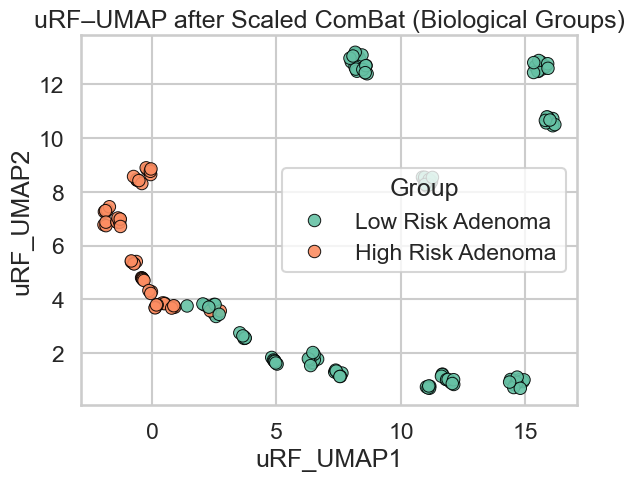

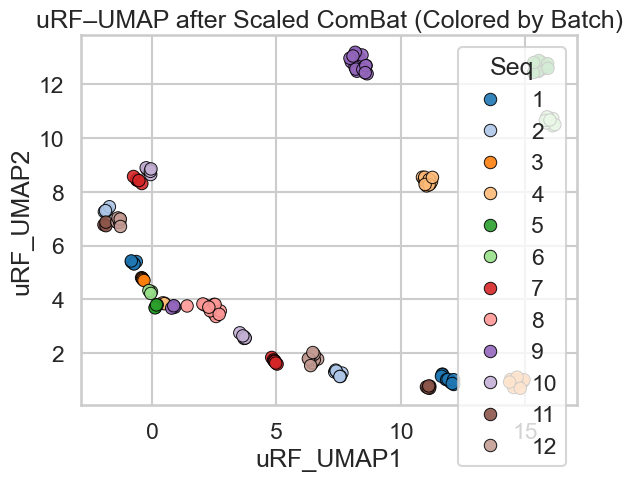

In [45]:
# ============================================================
# Batch Correction & uRF–UMAP (After ComBat)
# ============================================================
"""
Goal:
To visualize how batch correction (using ComBat) alters the structure of VOC data,
and to check whether biological differences (HRA vs LRA) are preserved after
removing technical batch effects.

Why this step?
In the baseline UMAP, sample separation may have reflected sequencing or instrument
batch differences (technical variation). Here, we correct for those effects using
the neuroCombat algorithm while preserving biological subgroup variation.
"""

# Standardize before ComBat 
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)

# Define covariates 
covars = pd.DataFrame({
    "Batch": df_real["Seq"],
    "Subgroup": df_real["Study subgroup"]
}, index=df_real.index)

#  Run ComBat with scaling 
combat_result = neuroCombat(
    dat=X_scaled.T,
    covars=covars,
    batch_col="Batch",
    categorical_cols=["Subgroup"]
)
X_combat = pd.DataFrame(combat_result["data"].T, index=X.index, columns=X.columns)
print(" ComBat (scaled) complete!")

# Continue with URF + UMAP 
X_real = X_combat.values
X_perm = np.random.permutation(X_real)
y_unsup = np.concatenate([np.ones(len(X_real)), np.zeros(len(X_perm))])
X_unsup = np.vstack([X_real, X_perm])

rf.fit(X_unsup, y_unsup)

leaf_indices = rf.apply(X_real)
n_trees = leaf_indices.shape[1]
n_samples = leaf_indices.shape[0]
proximity = np.zeros((n_samples, n_samples))

for tree in range(n_trees):
    leaves = leaf_indices[:, tree]
    for leaf in np.unique(leaves):
        idx = np.where(leaves == leaf)[0]
        proximity[np.ix_(idx, idx)] += 1
proximity /= n_trees

# UMAP 
import umap
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="precomputed",
    random_state=42
)
embedding = reducer.fit_transform(1 - proximity)
df_real["uRF_UMAP1"] = embedding[:, 0]
df_real["uRF_UMAP2"] = embedding[:, 1]

#Plot 1: by subgroup
sns.scatterplot(
    data=df_real, x="uRF_UMAP1", y="uRF_UMAP2",
    hue="Group", palette="Set2", s=80, edgecolor="black", alpha=0.9
)
plt.title("uRF–UMAP after Scaled ComBat (Biological Groups)")
plt.show()

# Plot 2: by batch
sns.scatterplot(
    data=df_real, x="uRF_UMAP1", y="uRF_UMAP2",
    hue="Seq", palette="tab20", s=80, edgecolor="black", alpha=0.9
)
plt.title("uRF–UMAP after Scaled ComBat (Colored by Batch)")
plt.show()


[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


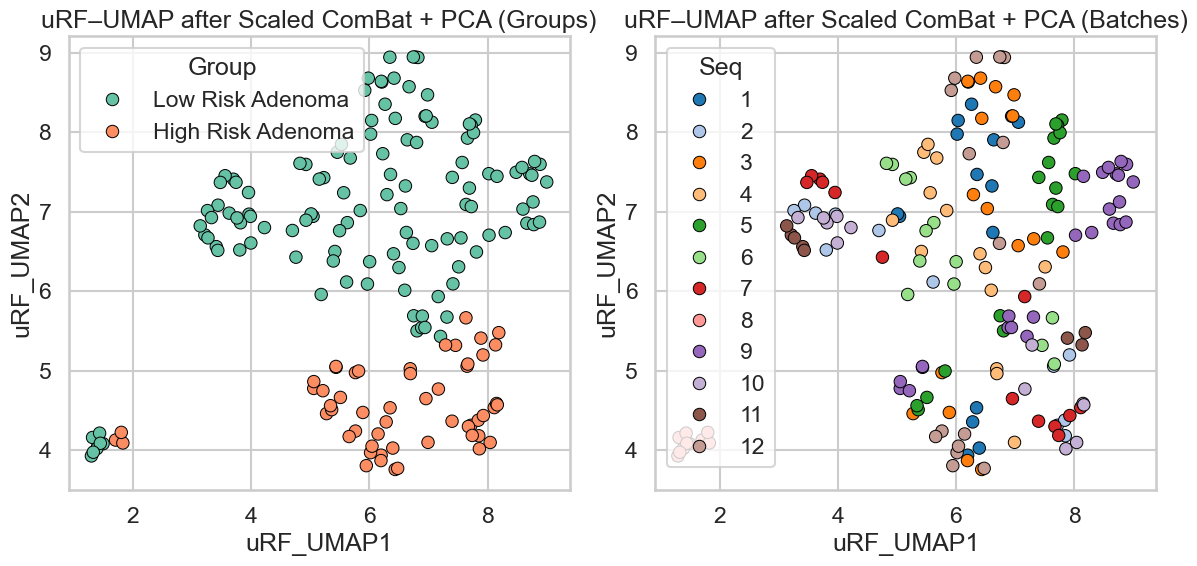

In [47]:
# ============================================================
# SECTION 3 — Scaled ComBat + PCA Smoothing + uRF–UMAP
# ============================================================
"""
Goal:
To refine the batch-corrected dataset by applying PCA smoothing
before running the unsupervised Random Forest (uRF) and UMAP visualization.

Why add PCA?
After ComBat correction, some residual noise and feature-level variance
may remain. PCA helps to:
  - Denoise the data by capturing only the dominant variance components,
  - Reduce dimensionality (simplify highly correlated VOC space),
  - Stabilize the uRF proximity computation (less random variability).

This version focuses on overall structure rather than individual VOC-level noise.
"""

#  Full (scaled) ComBat correction 
covars = pd.DataFrame({
    "Batch": df_real["Seq"],
    "Subgroup": df_real["Study subgroup"]
}, index=df_real.index)

combat_result = neuroCombat(
    dat=X_scaled.T,
    covars=covars,
    batch_col="Batch",
    categorical_cols=["Subgroup"]
)
X_combat = pd.DataFrame(combat_result["data"].T, index=X_scaled.index, columns=X_scaled.columns)

# PCA smoothing 
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_combat)

#  uRF as before 
X_real = X_pca
X_perm = np.random.permutation(X_real)
y_unsup = np.concatenate([np.ones(len(X_real)), np.zeros(len(X_perm))])
X_unsup = np.vstack([X_real, X_perm])

rf = RandomForestClassifier(
    n_estimators=1000,
    max_features="sqrt",
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_unsup, y_unsup)

leaf_indices = rf.apply(X_real)
n_trees = leaf_indices.shape[1]
n_samples = leaf_indices.shape[0]
proximity = np.zeros((n_samples, n_samples))
for tree in range(n_trees):
    leaves = leaf_indices[:, tree]
    for leaf in np.unique(leaves):
        idx = np.where(leaves == leaf)[0]
        proximity[np.ix_(idx, idx)] += 1
proximity /= n_trees

# UMAP embedding 
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="precomputed",
    random_state=42
)
embedding = reducer.fit_transform(1 - proximity)
df_real["uRF_UMAP1"], df_real["uRF_UMAP2"] = embedding[:,0], embedding[:,1]

# --- Plots ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(data=df_real, x="uRF_UMAP1", y="uRF_UMAP2",
                hue="Group", palette="Set2", s=80, edgecolor="black", ax=axes[0])
axes[0].set_title("uRF–UMAP after Scaled ComBat + PCA (Groups)")

sns.scatterplot(data=df_real, x="uRF_UMAP1", y="uRF_UMAP2",
                hue="Seq", palette="tab20", s=80, edgecolor="black", ax=axes[1])
axes[1].set_title("uRF–UMAP after Scaled ComBat + PCA (Batches)")
plt.tight_layout()
plt.show()


[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
 Scaled ComBat correction complete!
PCA smoothing complete!
Global z-score normalization complete!
Random forest trained for uRF proximity.
Proximity matrix computed.
UMAP embedding complete!


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


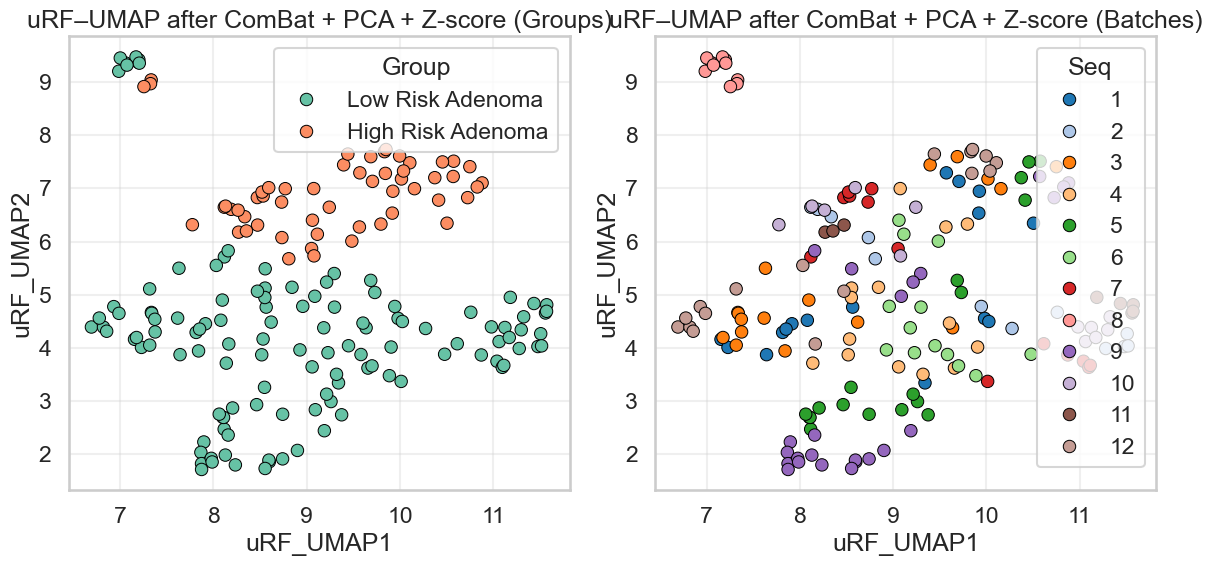

Silhouette (Group): 0.333  |  Silhouette (Batch): -0.042


In [51]:
# ============================================================
# 🧩 FINAL SECTION — Scaled ComBat + PCA + Z-score + uRF–UMAP
# ============================================================
"""
Goal:
To produce the final unsupervised embedding of the dataset after
complete preprocessing — scaling, batch correction, denoising (PCA),
and normalization — using an Unsupervised Random Forest (uRF) followed
by UMAP visualization.

This version aims for the most balanced tradeoff between:
biological signal preservation, batch effect removal, noise reduction and interpretability
"""


#Standardize raw data 
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)

#Prepare covariates for ComBat 
covars = pd.DataFrame({
    "Batch": df_real["Seq"],                # batch column
    "Subgroup": df_real["Study subgroup"]   # biological variable
}, index=df_real.index)

#Scaled ComBat batch correction 
combat_result = neuroCombat(
    dat=X_scaled.T,
    covars=covars,
    batch_col="Batch",
    categorical_cols=["Subgroup"]
)
X_combat = pd.DataFrame(
    combat_result["data"].T,
    index=X_scaled.index,
    columns=X_scaled.columns
)
print(" Scaled ComBat correction complete!")

# PCA smoothing 
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_combat)
print("PCA smoothing complete!")

# Post-ComBat z-score normalization 
scaler2 = StandardScaler()
X_z = scaler2.fit_transform(X_pca)
print("Global z-score normalization complete!")

# Unsupervised Random Forest 
X_real = X_z
X_perm = np.random.permutation(X_real)
y_unsup = np.concatenate([
    np.ones(len(X_real)),
    np.zeros(len(X_perm))
])
X_unsup = np.vstack([X_real, X_perm])

rf = RandomForestClassifier(
    n_estimators=1000,
    max_features="sqrt",
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_unsup, y_unsup)
print("Random forest trained for uRF proximity.")

# Compute proximity matrix 
leaf_indices = rf.apply(X_real)
n_trees = leaf_indices.shape[1]
n_samples = leaf_indices.shape[0]
proximity = np.zeros((n_samples, n_samples))
for tree in range(n_trees):
    leaves = leaf_indices[:, tree]
    for leaf in np.unique(leaves):
        idx = np.where(leaves == leaf)[0]
        proximity[np.ix_(idx, idx)] += 1
proximity /= n_trees
print("Proximity matrix computed.")

# UMAP embedding 
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="precomputed",
    random_state=42
)
embedding = reducer.fit_transform(1 - proximity)
df_real["uRF_UMAP1"] = embedding[:, 0]
df_real["uRF_UMAP2"] = embedding[:, 1]
print("UMAP embedding complete!")

#  Visualization 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(
    data=df_real, x="uRF_UMAP1", y="uRF_UMAP2",
    hue="Group", palette="Set2", s=80,
    edgecolor="black", ax=axes[0]
)
axes[0].set_title("uRF–UMAP after ComBat + PCA + Z-score (Groups)")
axes[0].grid(alpha=0.3)

sns.scatterplot(
    data=df_real, x="uRF_UMAP1", y="uRF_UMAP2",
    hue="Seq", palette="tab20", s=80,
    edgecolor="black", ax=axes[1]
)
axes[1].set_title("uRF–UMAP after ComBat + PCA + Z-score (Batches)")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Silhouette check (optional)
sil_group = silhouette_score(df_real[["uRF_UMAP1", "uRF_UMAP2"]], df_real["Group"])
sil_batch = silhouette_score(df_real[["uRF_UMAP1", "uRF_UMAP2"]], df_real["Seq"])
print(f"Silhouette (Group): {sil_group:.3f}  |  Silhouette (Batch): {sil_batch:.3f}")
